In [750]:
import numpy as np
import pandas as pd
from datetime import datetime
from itertools import cycle

from statsmodels.tsa.stattools import adfuller



import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,LSTM,GRU, Bidirectional, Embedding

### Import data

In [751]:
raw_df = pd.read_csv('./data.csv', index_col=0)
raw_df.index = pd.to_datetime(raw_df.index)
air_features = raw_df.columns[:6]
labels = raw_df.columns[6:8]
raw_df = raw_df.drop([col for col in raw_df.columns if col not in air_features and col not in labels], axis=1)
raw_df = raw_df.iloc[35:]
raw_df

,NO2,CO,PM25,OZONE,PM10,NO,new_confirmed_cases,new_deaths
Date,,,,,,,,
2020-03-01,0.007,0.3390,11.1,0.045,24.2,0.002,0.0,0.0
2020-03-02,0.022,0.4320,8.4,0.043,26.0,0.027,0.0,0.0
2020-03-03,0.029,0.5480,9.4,0.038,27.8,0.032,0.0,0.0
2020-03-04,0.021,0.5490,15.8,0.029,42.1,0.016,6.0,0.0
2020-03-05,0.029,0.5400,22.1,0.033,44.5,0.028,4.0,0.0
...,...,...,...,...,...,...,...,...
2020-10-14,0.040,1.0230,22.4,0.060,47.0,0.049,1223.0,19.0
2020-10-15,0.057,0.7690,22.9,0.059,48.8,0.054,1201.0,22.0
2020-10-16,0.041,0.7105,21.4,0.050,50.9,0.034,1041.0,22.0


### Data Analysis

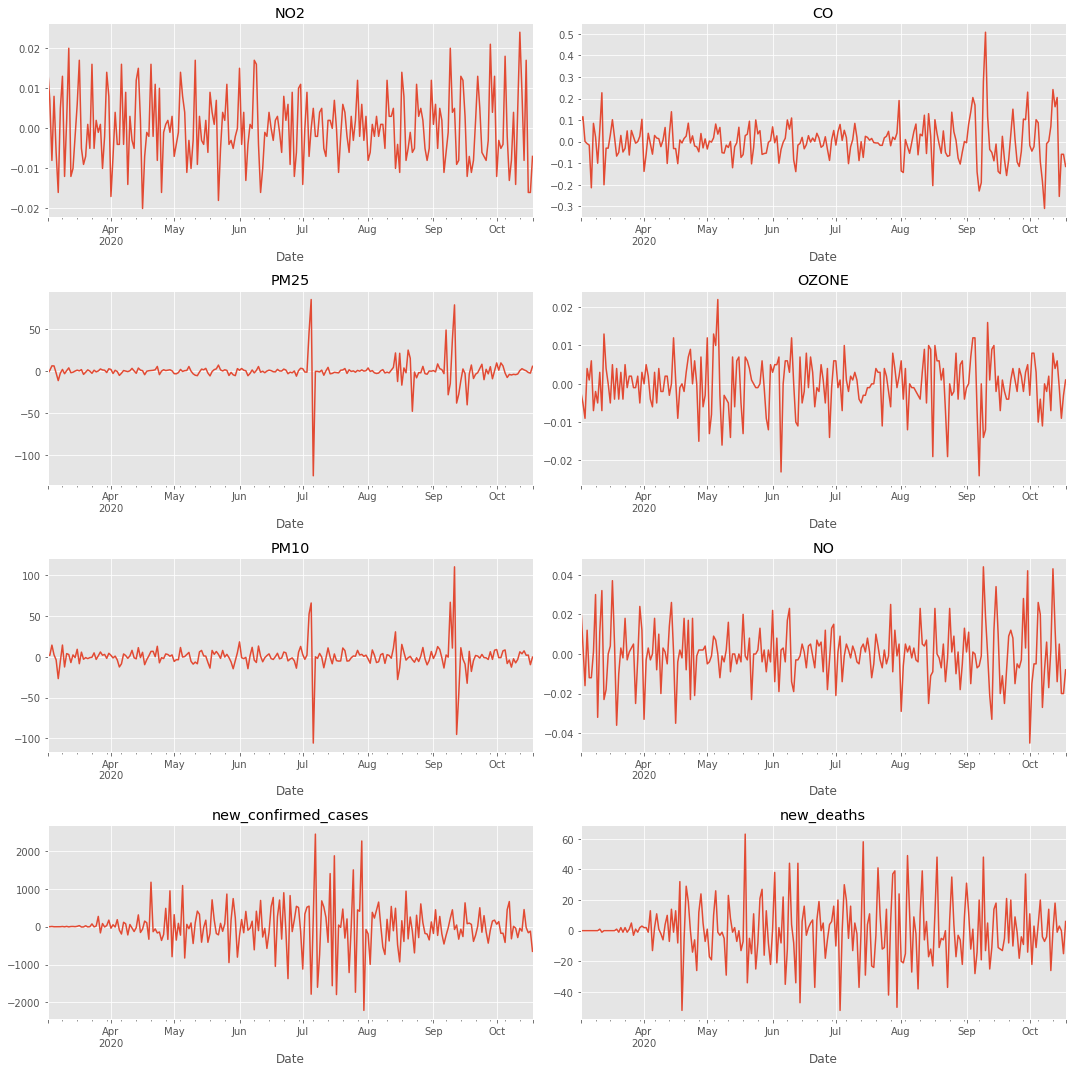

In [752]:
# Plot each series in dataframe
fig,ax = plt.subplots(4,2,figsize=(15,15))

for (i,column), j in zip(enumerate([col for col in raw_df.columns]), cycle([0,1])):
    df[column].plot(ax=ax[i//2, j])
    ax[i//2, j].set_title(column)
    
fig.tight_layout()

In [753]:
# Test for stationarity
d_count = 0
stationary = False

def stationary_check(df):
    stationary = True
    for col in df.columns:
        stationary = True
        adf = adfuller(df[col])[0]
        p = adfuller(df[col])[1]
        adf_conf = adfuller(df[col])[4]['10%']
        if p >= 0.5:
            stationary = False

        if adf >= adf_conf:
            stationary = False
            
    return stationary

def difference(df):
    global d_count
    stationary_df = df.copy(deep=True)

    for col in df.columns:
        stationary_df[col] = df[col] - df[col].shift(1)
        
    d_count += 1
    return stationary_df

stationary = stationary_check(raw_df)

stationary_df = raw_df.copy(deep=True)

if not stationary:
    print('Data not stationary. Differencing data and checking again.')

    while not stationary:
        stationary_df = difference(stationary_df)
        stationary = stationary_check(stationary_df.dropna())
        
stationary_df = stationary_df.dropna()
print(f'{d_count} rounds of differencing.')

Data not stationary. Differencing data and checking again.
1 rounds of differencing.


In [816]:
def series_to_supervised(data, n_in_start=1, n_in_stop=0, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] - 2
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in_start, n_in_stop, -1):
        cols.append(df.iloc[:, : 6].shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    names += ['var7(t)', 'var8(t)']
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

def training(trainX, trainY, testX, testY):
    stop_noimprovement = EarlyStopping(monitor='val_loss', verbose=1, patience=30, min_delta=.00001)
    model = Sequential()
    model.add(LSTM(20,return_sequences=True, input_shape=(trainX.shape[1],trainX.shape[2])))
    model.add(LSTM(60,return_sequences=True))
    model.add(LSTM(100,return_sequences=True))
    model.add(LSTM(40,return_sequences=True))
    model.add(LSTM(20,return_sequences=True))
    model.add(LSTM(4))
    model.add(Dense(2))
    model.compile(loss="mse",optimizer="adam")
    print(model.summary())
    history = model.fit(trainX,trainY,validation_data=(testX,testY),epochs=200,verbose=1,callbacks=[stop_noimprovement],shuffle=False)
    return history, model

def prediction(model, testX, testY):
    predicted = model.predict(testX)
    testXRe = testX.reshape(testX.shape[0],testX.shape[2])
    
    predicted = np.concatenate((testXRe[:,:-2], predicted),axis=1)
    predicted = scaler.inverse_transform(predicted[:,-8:])
    
    new_cases_rmse = np.sqrt(mean_squared_error(testY[:,-2],predicted[:,-2]))
    new_deaths_rmse = np.sqrt(mean_squared_error(testY[:,-1],predicted[:,-1]))
    return new_cases_rmse, new_deaths_rmse

def plots(histories):
    
    fig = plt.figure()
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='test')
    plt.legend()
    plt.show()
    
def nRMSE(rmse, series):
    return rmse/(series.max() - series.min())

In [817]:
values = raw_df.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(-1,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled,6,0,1)
reframed.drop(reframed.columns[[-3,-4,-5,-6,-7,-8]], axis=1, inplace=True)
values = reframed.values

In [818]:
n_train = int(len(reframed)*.9)

train = values[:n_train]
test = values[n_train:]
trainX,trainY = train[:,:-2],train[:,-2:]
testX,testY = test[:,:-2],test[:,-2:]
trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
testX = testX.reshape(testX.shape[0],1,testX.shape[1])

In [819]:
history, model = training(trainX, trainY, testX, testY)

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_214 (LSTM)              (None, 1, 20)             4560      
_________________________________________________________________
lstm_215 (LSTM)              (None, 1, 60)             19440     
_________________________________________________________________
lstm_216 (LSTM)              (None, 1, 100)            64400     
_________________________________________________________________
lstm_217 (LSTM)              (None, 1, 40)             22560     
_________________________________________________________________
lstm_218 (LSTM)              (None, 1, 20)             4880      
_________________________________________________________________
lstm_219 (LSTM)              (None, 4)                 400       
_________________________________________________________________
dense_67 (Dense)             (None, 2)               

203/203 [==============================] - 0s 1ms/sample - loss: 0.1111 - val_loss: 0.0503
Epoch 68/200
203/203 [==============================] - 0s 1ms/sample - loss: 0.1108 - val_loss: 0.0504
Epoch 69/200
203/203 [==============================] - 0s 1ms/sample - loss: 0.1104 - val_loss: 0.0505
Epoch 70/200
203/203 [==============================] - 0s 1ms/sample - loss: 0.1101 - val_loss: 0.0507
Epoch 71/200
203/203 [==============================] - 0s 1ms/sample - loss: 0.1099 - val_loss: 0.0508
Epoch 72/200
203/203 [==============================] - 0s 1ms/sample - loss: 0.1096 - val_loss: 0.0509
Epoch 00072: early stopping


In [ ]:
plots(history)

Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_core/python/autograph/pyct/compiler.py", line 103, in <lambda>
    atexit.register(lambda: os.remove(f.name))
FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/60/7nwlbdls72v0x4qy8cdpsvg00000gn/T/tmpodvki0nm.py'


In [821]:
cases_rmse, deaths_rmse = prediction(model, testX, testY)
print(f'Cases RMSE:\n\t{cases_rmse:.2f} cases \n\t{nRMSE(cases_rmse, df["new_confirmed_cases"])*100:.2f}% nRMSE')
print(f'Deaths RMSE:\n\t{deaths_rmse:.2f} deaths \n\t{nRMSE(deaths_rmse, df["new_deaths"])*100:.2f}% nRMSE')

Cases RMSE:
	1024.12 cases 
	21.97% nRMSE
Deaths RMSE:
	27.12 deaths 
	23.58% nRMSE
